In [67]:
# Import requiured libraries
import os
import glob
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from skimage import io, transform
from skimage.io import imread
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [56]:
print ("1. Loading data & Converting data")
print ("----------------------------------------")
root="/media/haidro/harddisk1t/kaggle/protein_atlas"
print('Data files: ')
for file in os.listdir(root):
    print(file) 
print ("----------------------------------------")
train_label = pd.read_csv(root+"/train.csv")
print("There is %s samples in traininig set."%train_label.shape[0])
test_label = pd.read_csv(root+"/sample_submission.csv")
print("There is %s samples in testing set."%test_label.shape[0])
print ("----------------------------------------")
print ("There are in total 28 different labels present in the dataset, each image has various possible labels.")
# train_label
train_label.head()

1. Loading data & Converting data
----------------------------------------
Data files: 
test
.ipynb_checkpoints
sample_submission.csv
train
train.csv
----------------------------------------
There is 31072 samples in traininig set.
There is 11702 samples in testing set.
----------------------------------------
There are in total 28 different labels present in the dataset, each image has various possible labels.


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [57]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_label = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row
for key in label_names.keys():
    train_label[label_names[key]] = 0
train_label = train_label.apply(fill_targets, axis=1)

train_label=train_label.drop(['Target'],axis=1)
train_label.head()

,Id,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [96]:
## Define a dataloader function for protein dataset
class protein(Dataset):
    def __init__(self, train=True):
        self.train= train
        self.transform=transform
        if train:
            self.df=train_label
            self.path=root+"/train/"
        else:
            self.path=root+'/test/'

    def __getitem__(self, idx):
        Id=self.df['Id'].iloc[idx]
        Targets=self.df.loc[idx,df.columns!='Id']
        images = np.zeros(shape=(512,512,4))
        images[:,:,0] = np.asarray(Image.open(self.path + Id + "_red" + ".png"))
        images[:,:,1] = np.asarray(Image.open(self.path + Id + "_green" + ".png"))
        images[:,:,2] = np.asarray(Image.open(self.path + Id + "_blue" + ".png"))
        images[:,:,3] = np.asarray(Image.open(self.path + Id + "_yellow" + ".png"))
        images = transforms.ToTensor()(images).view(4,512,512),float()
        images = transforms.Normalize(mean=(0.5,),std=(0.5,))(images)
        
        sample = {'Id': Id, 'Targets': Targets, 'Images':images}
    
        return sample
    
    def __len__(self):
          return len(self.df)

In [97]:
data_set=protein(train=True)
test_set=protein(train=False)

In [98]:
num_data = len(data_set)
indices = list(range(num_data))
##split set into train set and validation set
train_size = int(0.7 * len(data_set))
valid_size = len(data_set) - train_size
train_set, valid_set = torch.utils.data.random_split(data_set, [train_size, valid_size])
print('Number of images in the whole data set: {0}'.format(num_data))
print('Number of images in the training set: {0}'.format(train_size))
print('Number of images in the validation set: {0}'.format(valid_size))

Number of images in the whole data set: 31072
Number of images in the training set: 21750
Number of images in the validation set: 9322


##### Load the data into Tensors

In [99]:
## Data Loader with different batch_size
train_loader= data_utils.DataLoader(train_set, batch_size=32, shuffle = True)
validation_loader= data_utils.DataLoader(valid_set, batch_size=128, shuffle = True)
test_loader=data_utils.DataLoader(test_set,batch_size=128,shuffle=True)

In [95]:
 for batch_idx, sample in enumerate(train_loader):
        print(sample)

TypeError: object of type 'numpy.int64' has no len()

In [87]:
class Protein_Net(torch.nn.Module):
    def __init__(self):
        ## Network Structure
        super(Protein_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 28)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3,3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1,1))
        self.bn6 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x),2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x,2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size =  x.size()[1]*x.size()[2]*x.size()[3]
        #print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training and Evaluation the network

In [89]:
# move the model to cuda 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = Protein_Net().to(device)
## Construct an optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.05)
criterion = nn.CrossEntropyLoss()

train_accu_list=[]
train_loss_list=[]
test_accu_list=[]
test_loss_list=[]
iter_list=[]
iter=0
epochs=40
for epoch in range(epochs):
    # training phase
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, sample in enumerate(train_loader):
        # move the variable to cuda
        x, target = sample['Images'].to(device),sample['Targets'].to(device)
        # clear out the gradients accumulated for the parameters of the network
        optimizer.zero_grad()
        out = model(x)
        # compute the loss function
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        # back-prop all the layers
        loss.backward()
        # update the parameters
        optimizer.step()
        iter+=1
        if (batch_idx+1) % 1000 == 0 or (batch_idx+1) == len(train_loader):
            print('epoch: [{}/{}], batch index: {}, train loss: {:.4f}, acc: {:.3f}'.format(
                epoch+1,epochs, batch_idx+1, ave_loss, correct_cnt*1.0/total_cnt))
            train_accu_list.append(correct_cnt*1.0/total_cnt)
            train_loss_list.append(ave_loss)
            iter_list.append(iter)
    # testing phase
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(validation_loader):
        x, target = sample['Images'].to(device),sample['Targets'].to(device)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if (batch_idx+1) % 110 == 0 or (batch_idx+1) == len(test_loader):
            print('epoch: [{}/{}], batch index: {}, test loss: {:.4f}, acc: {:.3f}'.format(
                epoch+1, epochs, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))
            test_accu_list.append(correct_cnt*1.0/total_cnt)
            test_loss_list.append(ave_loss)
    

# Save the trained model
torch.save(model.state_dict(),'./not_mnist_cnn.ckpt')

TypeError: object of type 'numpy.int64' has no len()

### Plot
Reaches 0.928 accuracy on test set after 40 epochs

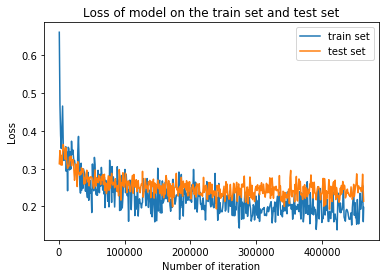

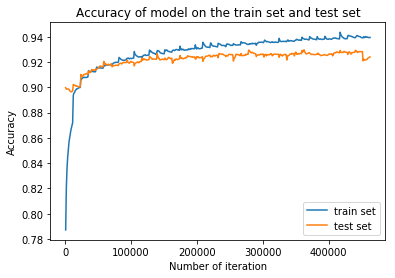

In [234]:
# plot loss of the model on the train set and test set
plt.plot(iter_list,train_loss_list,label='train set')
plt.plot(iter_list,test_loss_list,label='test set')
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel('Loss')
plt.title('Loss of model on the train set and test set')
plt.show()
# plot accuracy of the model on the train set and test set
plt.plot(iter_list,train_accu_list,label='train set')
plt.plot(iter_list,test_accu_list,label='test set')
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel('Accuracy')
plt.title('Accuracy of model on the train set and test set')
plt.show()